In [ ]:
"""
cd /home/zihao/llm/llm4rec/index
bash run.sh

引入scale后码本冲突率下降
layers 512 256 128 -> 512 256 128 64后, train loss下降

分析指标: loss, collision_rate, utilization, perplexity
"""

In [6]:
import re
import pandas as pd

def parse_rqvae_log(filepath, num_layers=3, print_last=True):
    """
    解析RQVAE日志，返回loss_df和eval_df
    注意：eval_df的epoch字段现在严格来自于“epoch N evaluating ...”而不是training。
    """
    epochs, train_loss, recon_loss = [], [], []
    collision_rates = []
    utilization_records = [[] for _ in range(num_layers)]
    perplexity_records = [[] for _ in range(num_layers)]
    eval_epochs = []

    with open(filepath, encoding="utf-8") as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        # 提取训练阶段信息
        m_tr = re.search(r"epoch (\d+) training.*train loss.*?: ([0-9.]+),.*reconstruction loss.*?: ([0-9.]+)", line)
        if m_tr:
            epochs.append(int(m_tr.group(1)))
            train_loss.append(float(m_tr.group(2)))
            recon_loss.append(float(m_tr.group(3)))

        # 提取评估阶段信息及当前epoch
        m_ev = re.search(r"epoch (\d+) evaluating.*collision_rate.*?: ([0-9.]+)", line)
        if m_ev:
            this_epoch = int(m_ev.group(1))
            eval_epochs.append(this_epoch)  # 现在严格来源于evaluating
            collision_rates.append(float(m_ev.group(2)))
            # 从下方逐层匹配Utilization与Perplexity
            for j in range(num_layers):
                lidx = i + j + 1
                if lidx < len(lines):
                    l = lines[lidx]
                    m_layer = re.search(
                        r"Layer (\d+):.*?Utilization.*?=([0-9.]+) \((\d+)/(\d+)\), .*?Perplexity.*?=([0-9.]+)",
                        l,
                    )
                    if m_layer:
                        lid = int(m_layer.group(1))
                        if 0 <= lid < num_layers:
                            # 对齐补全None
                            while len(utilization_records[lid]) < len(collision_rates) - 1:
                                utilization_records[lid].append(None)
                            while len(perplexity_records[lid]) < len(collision_rates) - 1:
                                perplexity_records[lid].append(None)
                            utilization_records[lid].append(float(m_layer.group(2)))
                            perplexity_records[lid].append(float(m_layer.group(5)))
            # 若某一层没有信息也要补齐None
    for arr in [utilization_records, perplexity_records]:
        for l in arr:
            while len(l) < len(collision_rates):
                l.append(None)

    if print_last and epochs:
        print(f"epoch {epochs[-1]}")
        print(f"train loss: {train_loss[-1]}")
        print(f"reconstruction loss: {recon_loss[-1]}")
        print(f"collision_rate: {collision_rates[-1] if collision_rates else 'N/A'}")
        for lid in range(num_layers):
            print(f"Layer {lid}: Utilization={utilization_records[lid][-1]}, Perplexity={perplexity_records[lid][-1]}")

    # 组装DataFrame
    loss_df = pd.DataFrame({
        "epoch": epochs,
        "train_loss": train_loss,
        "recon_loss": recon_loss
    })

    eval_data = {
        "epoch": eval_epochs,
        "collision_rate": collision_rates
    }
    for lid in range(num_layers):
        eval_data[f"utilization_{lid}"] = utilization_records[lid][:len(collision_rates)]
        eval_data[f"perplexity_{lid}"] = perplexity_records[lid][:len(collision_rates)]

    eval_df = pd.DataFrame(eval_data)
    return loss_df, eval_df

# 用法示例
log_file = "../index/log_scale12.0.txt"
loss_df, eval_df = parse_rqvae_log(log_file, num_layers=3, print_last=False)

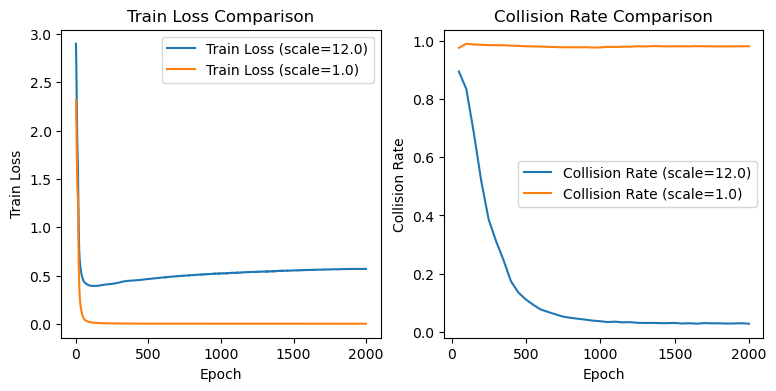

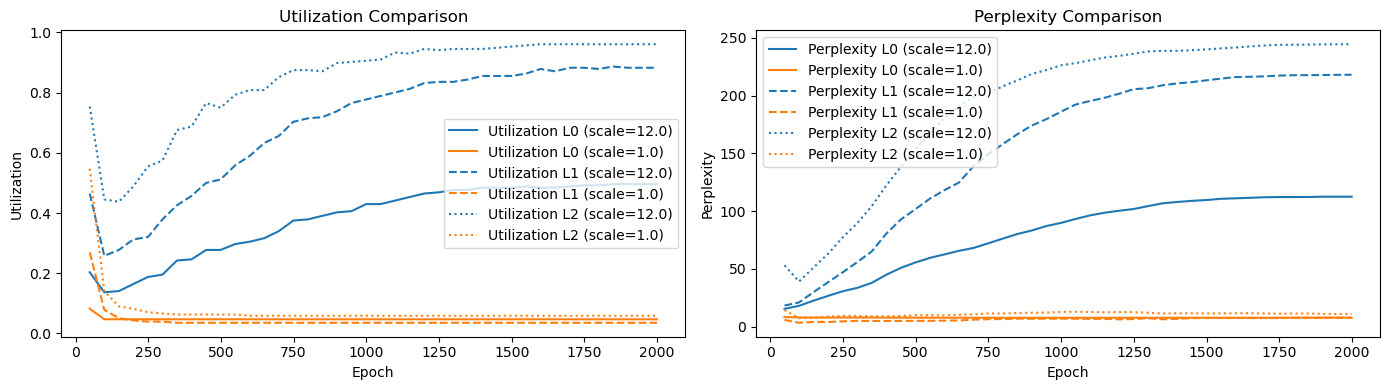

In [9]:
import matplotlib.pyplot as plt

# 读取 scale 12.0 和 scale 1.0 的日志文件
log_file_12 = "../index/log_scale12.0.txt"
log_file_1 = "../index/log_scale1.0.txt"

loss_df_12, eval_df_12 = parse_rqvae_log(log_file_12, num_layers=3, print_last=False)
loss_df_1, eval_df_1 = parse_rqvae_log(log_file_1, num_layers=3, print_last=False)

colors = {
    "12.0": "tab:blue",
    "1.0": "tab:orange"
}
linestyles = ["-", "--", ":"]  # 三个层

# 1. 绘制 loss 对比
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(loss_df_12["epoch"], loss_df_12["train_loss"], label="Train Loss (scale=12.0)", color=colors["12.0"])
plt.plot(loss_df_1["epoch"], loss_df_1["train_loss"], label="Train Loss (scale=1.0)", color=colors["1.0"])
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss Comparison")
plt.legend()

# 2. 绘制 collision_rate 对比
plt.subplot(1, 3, 2)
plt.plot(eval_df_12["epoch"], eval_df_12["collision_rate"], label="Collision Rate (scale=12.0)", color=colors["12.0"])
plt.plot(eval_df_1["epoch"], eval_df_1["collision_rate"], label="Collision Rate (scale=1.0)", color=colors["1.0"])
plt.xlabel("Epoch")
plt.ylabel("Collision Rate")
plt.title("Collision Rate Comparison")
plt.legend()

# 3. utilization & perplexity，对每个scale三个层，线型区分层
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
for lid in range(3):
    plt.plot(
        eval_df_12["epoch"],
        eval_df_12[f"utilization_{lid}"],
        label=f"Utilization L{lid} (scale=12.0)",
        color=colors["12.0"],
        linestyle=linestyles[lid]
    )
    plt.plot(
        eval_df_1["epoch"],
        eval_df_1[f"utilization_{lid}"],
        label=f"Utilization L{lid} (scale=1.0)",
        color=colors["1.0"],
        linestyle=linestyles[lid]
    )
plt.xlabel("Epoch")
plt.ylabel("Utilization")
plt.title("Utilization Comparison")
plt.legend()

plt.subplot(1, 2, 2)
for lid in range(3):
    plt.plot(
        eval_df_12["epoch"],
        eval_df_12[f"perplexity_{lid}"],
        label=f"Perplexity L{lid} (scale=12.0)",
        color=colors["12.0"],
        linestyle=linestyles[lid]
    )
    plt.plot(
        eval_df_1["epoch"],
        eval_df_1[f"perplexity_{lid}"],
        label=f"Perplexity L{lid} (scale=1.0)",
        color=colors["1.0"],
        linestyle=linestyles[lid]
    )
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Perplexity Comparison")
plt.legend()

plt.tight_layout()
plt.show()